In [1]:
using Pkg

Pkg.activate("..")

using SymPy, DifferentialEquations, Plots, Optim
using Statistics, Distributions, LaTeXStrings, Random

include("./HelperScripts/temp_assembly.jl")

coef_var (generic function with 1 method)

# Introduction

In this notebook I will solve the mean-field model for equlibrial biomass and demonstrate its suitability as an approximation of Lotka-Volterra dynamics. 

# Solving the mean-field model

To solve the mean-field model we first define the vairables to be used:

In [38]:
#define vairables and thier avarge counterparts
x,ux = symbols("x,μ_x")
r,ur = symbols("r,μ_r")
k,uk = symbols("k,μ_k")
aii,uaii = symbols("a_{ii},μ_{a_{ii}}")
N, ua = symbols("N, μ_{a}")

#define mean-field to solve
f = r - aii*x - ua*ux

x_sol = SymPy.solve(f, x)[1]

r - μₓ⋅μ_{a}
────────────
   a_{ii}   

In [37]:
#take average
ux_f1 = subs(x_sol , r =>ur) - ux
ux_sol = SymPy.solve(ux_f1, ux)[1]

      μᵣ      
──────────────
a_{ii} + μ_{a}

In [39]:
x_sol_final = subs(x_sol, ux => ux_sol).simplify()

r⋅(a_{ii} + μ_{a}) - μᵣ⋅μ_{a}
─────────────────────────────
   a_{ii}⋅(a_{ii} + μ_{a})   

In [43]:
a = x_sol_final.args[1].args[1]
b = symbols("b")
c = x_sol_final.subs(a,b).expand().subs(b,a)

c.subs(aii, 1).simplify()

r⋅μ_{a} + r - μᵣ⋅μ_{a}
──────────────────────
      μ_{a} + 1       

which with some manual rearanging equilbirium biomass is given by: 

$$
C_i^* = K_i - \bar{K} \frac{\bar{a}(N-1) }{ 1 + \bar{a}(N-1)}
$$

## Feasibility

taking this the equation for biomass above we can obtain an expression for feasability by enforcing the condition:

$$
x > 0 \quad \text{for all} \quad i = 1,2,\dots, N
$$

which gives the expression

$$
\frac{K_i}{\bar{K}} > \frac{ \bar{a}(N-1) }{1 + \bar{a}(N-1)}
$$

Here I simulate randomly generated systems to show that this bound applies to the lottka-volterra system (if the assumptions of the mean-field are met). Note that I keep intraspecific interactions constant ($a_{ii} = 1$) to aid in the interpretation. 

In [47]:
Random.seed!(1)

#analytical bound
function bound(N,ā) 
    (ā*(N-1)) / ( (ā*(N-1)) + 1 )
end

#generate random communtiy
function generate_parameters(N, a_μ, r_σ)
    r = rand(Distributions.LogNormal(1.0,r_σ), N)
    a = -rand(Distributions.LogNormal( log(a_μ / N) , 0.5) ,N,N)
    [a[i,i] = -1.0 for i = 1:N]
    Param(N,r,a,0.0)
end

#simulation parameters
N = 50
x0 = rand(N) * 0.1
tspan = (0, 1e3)

# #replicate parameters
N_a, N_r, N_rep = 20 , 20 , 2
a_vec = range(0.0, 1.0, length = N_a)
r_vec = range(0.0, 1.0, length = N_r)

# #results array
feas_results = Array{Tuple{Float64,Vector{Float64},Bool},3}(undef, N_a, N_r, N_rep)

for i = 1:N_a, j = 1:N_r, k = 1:N_rep
    p = generate_parameters(N,a_vec[i],r_vec[j])    
    prob = ODEProblem(dx!, x0  , tspan, p)
    sol = DifferentialEquations.solve(prob)
    
    #realised parameters
    a = mean(sum(p.a,dims=2).+1) / (p.N-1)
    r = p.r ./ mean(p.r)
    
    feas_results[i,j,k] = -a,r, all(sol[end] .> eps())
end

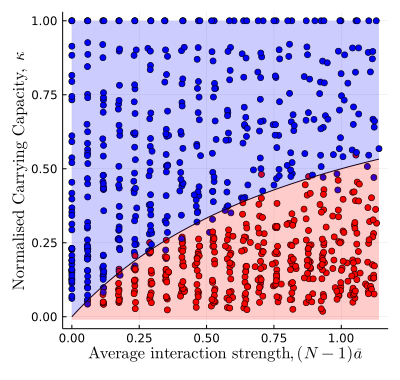

In [48]:
#plotting
#setup plotting arrays
x = [ feas_results[:][i][1] for i = 1:(N_a*N_r*N_rep) ]


y = [minimum(feas_results[:][i][2]) for i = 1:(N_a*N_r*N_rep)]
y = vcat(y...)

c = [all(feas_results[:][i][3]) for i = 1:(N_a*N_r*N_rep)]
c = vcat(c...)


col = fill(:red, N_a*N_r*N_rep)
col[c] .= :blue

p1 = scatter(x .* (N-1),y,color = col,
    ylab = L"\textrm{Normalised Carrying Capacity}, \ \kappa",
    xlab = L"\textrm{Average interaction strength},(N-1)\bar{a}")

xrange = range(minimum(x),maximum(x),length = 100)

plot!(p1, xrange .* (N-1), bound.(N, xrange), color = "black", lw = 1, size = (400,380))
plot!(p1, xrange .* (N-1), bound.(N, xrange), color = "Black", lw = 0, legend = false,fill = (-0.01,0.2,:red))
plot!(p1, xrange .* (N-1), bound.(N, xrange), color = "Black", lw = 0, legend = false,fill = (1,0.2,:blue))
savefig(p1, "../docs/Figures/Fig_1.pdf")

p1

# Probability of Feasibility

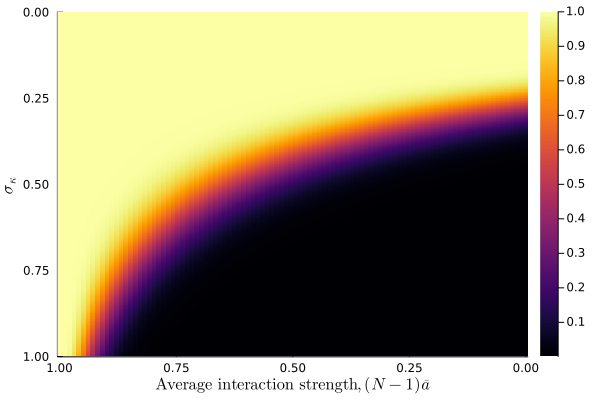

In [63]:
Random.seed!(1)

N = 50
# #replicate parameters
N_a, N_r = 100 , 500
a_vec = range(1.0, 0.0, length = N_a)
r_vec = range(0.0, 1.0, length = N_r)
res = Array{Float64,2}(undef, length(a_vec), length(r_vec) )

for i = eachindex(a_vec), j = eachindex(r_vec)
    dr = Distributions.LogNormal(-(r_vec[j]^2) / 2,  r_vec[j])
    da = Distributions.LogNormal( log(a_vec[i] / N) , 0.5)
    
    res[i,j] = (1-Distributions.cdf(dr, bound(N,mean(da))))^N
end


p2 = heatmap(reverse(a_vec),r_vec,res', yflip = true, xflip = true,
    xlab = L"\textrm{Average interaction strength},(N-1)\bar{a}",
    ylab = L"\sigma_{\kappa}")

# savefig(p2, "../docs/Figures/Fig_2.pdf")
# p2

# Temperature
So how can we include temperature in this?

We first observe that in the feasibility condidtion

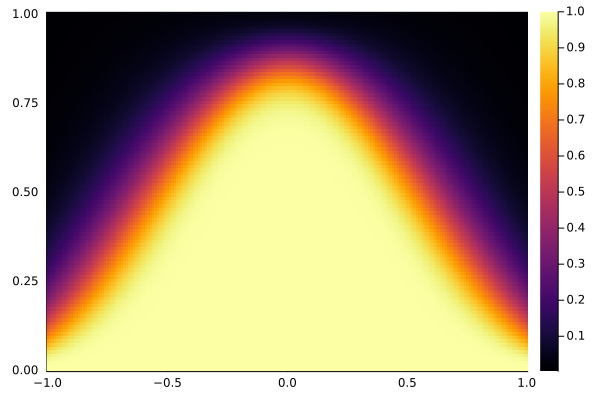

In [120]:
#returns distribution given thermal-sensitvtiy traits and temperature
# all TPC trait moments are for normal versions
function distributions(T, μr0, σr0, μEr, σEr, μa0, σa0, μEa, σEa)
    μr = μr0 - μEr * T
    σr = σr0^2 + σEr^2 * T^2
    dr = Distributions.LogNormal(μr,σr)

    μa = μa0 - μEa * T
    σa = σa0^2 + σEa^2 * T^2
    da = Distributions.LogNormal(μa,σa)
    
    return(dr,da)
end

#returns the bound at temp T - enforce competition
function bound_T(T,N, μr0, σr0, μEr, σEr, μa0, σa0, μEa, σEa)
    dr,da = distributions(T, μr0, σr0, μEr, σEr, μa0, σa0, μEa, σEa)
    ā = mean(da)
    return(bound(N,ā))
end

#returns the pdf of kappa at T - supply non-normalised moments
function κ_pdf(T,θ,N, μr0, σr0, μEr, σEr, μa0, σa0, μEa, σEa)
    dr,da = distributions(T, μr0, σr0, μEr, σEr, μa0, σa0, μEa, σEa)
    dr_norm = Distributions.LogNormal(-(dr.σ^2) / 2, dr.σ)
    return( Distributions.pdf(dr_norm, θ) )
end

#returns the probability of feasibiltiy
function κ_feas(T, θ, N, μr0, σr0, μEr, σEr, μa0, σa0, μEa, σEa)
    dr,da = distributions(T, μr0, σr0, μEr, σEr, μa0, σa0, μEa, σEa)
    dr_norm = Distributions.LogNormal(-(dr.σ^2) / 2, dr.σ)
    (1 - Distributions.cdf(dr_norm, θ))^N
end

μr0, σr0, μEr, σEr = 0.0,      0.35, 0.0, 1.0
μa0, σa0, μEa, σEa = log(0.1), 0.5, 0.0, 0.5

T = -1:0.01:1.0
θ = 0:0.01:1.0
N = 5

p_κ = hcat([κ_feas.(T, θ, N, μr0, σr0, μEr, σEr, μa0, σa0, μEa, σEa) for θ = θ]...)
p1 = heatmap(T,θ,p_κ')

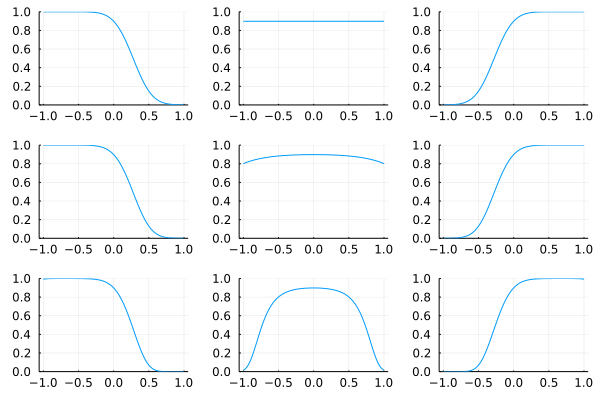

In [121]:
#varying μE and σE
μr0, σr0, μEr, σEr = 0.0,      0.25, 0.0, 0.0
μa0, σa0, μEa, σEa = log(0.1), 0.5, 0.0, 0.0

μEa_vec = range(-1.0,1.0,length = 3)
σEa_vec = range(0.0,1.0,length = 3)

T = -1:0.01:1.0
θ = 0:0.01:1.0
N = 50

res = Array{Any,2}(undef, length(μEa_vec), length(σEa_vec) )

for i = eachindex(μEa_vec), j = eachindex(σEa_vec)
    bound_vec = bound_T.(T,N, μr0, σr0, μEr, σEr, μa0, σa0, μEa_vec[i], σEa_vec[j])
    P_feas_vec = κ_feas.(T, bound_vec, N, μr0, σr0, μEr, σEr, μa0, σa0, μEa_vec[i], σEa_vec[j])
    
    res[i,j] = plot(T, P_feas_vec)
end

l = @layout(grid(length(σEa_vec), length(μEa_vec)))

p = plot(res..., layout = l, ylim = (0,1), legend = false)

savefig(p, "../docs/Figures/P_feas_grid.pdf")

p

# Species richness

In [126]:
#get T-dependent parameters
struct TpcParameters
    μK0::Float64
    σK0::Float64
    μEK::Float64
    σEK::Float64
    
    μa0::Float64
    σa0::Float64
    μEa::Float64
    σEa::Float64
end

#kappa distribution
function get_dK(Temp,p::TpcParameters)
    μK = p.μK0 - p.μEK*Temp
    σK = p.σK0^2 + (p.σEK^2 * Temp^2)
    
    return(Distributions.LogNormal(μK,σK))
end
     
#a distribution
function get_ā(Temp, p::TpcParameters)
    μa = p.μa0 - p.μEa * Temp
    σa = p.σa0^2 + (p.σEa^2 * Temp^2)
    
    da = Distributions.LogNormal(μa,σa)
    return(-mean(da))
end

#calculate p_feas
function p_feas(Temp,N,p::TpcParameters)
    #get ā
    ā = get_ā(Temp, p)
    dK = get_dK(Temp,p)
    dκ = Distributions.LogitNormal(-dK.σ^2 / 2 ,dK.σ)
    
    #calculate bound
    bound = (ā*(N-1)) / ( (ā*(N-1)) - 1)
    
    #calcualte P_feas
    (1 - cdf(dκ, bound))^N
end

function get_N(Temp, θ, p::TpcParameters)
    #function to optimise
    f(x) = abs(p_feas(Temp, x, p) .- θ)
    opt = optimize(f,0,90,GoldenSection())
    
    return(opt.minimizer)
end

function ΔTtoK(ΔT,Tref)
    1 / (((8.617e-5) * ΔT) + (1/Tref))
end


ΔTtoK (generic function with 1 method)

In [261]:
using DelimitedFiles

param_table = readdlm("../data/K_TPC_output.csv", ',')

keys = string.(param_table[:,1],"_",param_table[:,2])

obs_param = Dict(keys[i] => param_table[i, 3] for i = 2:5)

Dict{String, Float64} with 4 entries:
  "mean_K0"  => -0.144021
  "sd_E_K"   => 0.287376
  "mean_E_K" => 0.0565693
  "sd_K0"    => 0.575403

In [276]:
#results
μK0, μEK, σK0, σEK = obs_param["mean_K0"], obs_param["mean_E_K"], obs_param["sd_K0"], obs_param["sd_E_K"]
μa0, σa0 = log(0.01), 0.5

NE,N_Temp = 3, 25

#generate E ranges
μEa_vec = range(-0.65,0.65,length = NE)
σEa_vec = range(0.0,1.0,length = NE)

T_vec = range(-1,1, length = N_Temp)

#plots
res = Array{Float64, 3}(undef, NE, NE, N_Temp)

for i = eachindex(μEa_vec)
    for j = eachindex(σEa_vec)
        #define params
        p = TpcParameters(μK0, σK0, μEK, σEK, μa0, σa0, μEa_vec[i], σEa_vec[j])
        #get N
        K = ΔTtoK.(T_vec,293.15)
        res[i,j,:] = get_N.(T_vec, 0.8, Ref(p))
        
    end
end

writedlm("../data/sp_num_a_sig_0.0.csv",res[:,1,:]',',')
writedlm("../data/sp_num_a_sig_0.5.csv",res[:,2,:]',',')
writedlm("../data/sp_num_a_sig_1.0.csv",res[:,3,:]',',')

In [283]:
#for K
μK0, μEK, σK0, σEK = obs_param["mean_K0"], obs_param["mean_E_K"], obs_param["sd_K0"], obs_param["sd_E_K"]
μa0, σa0 = log(0.01), 0.5, 0.65, 0.2

#generate E ranges
σEK_vec = range(0.0,1.0,length = 3)


res = Array{Float64, 2}(undef, NE, N_Temp)

for i = eachindex(σEK_vec)
    #define params
    p = TpcParameters(μK0, σK0, μEa, σEK_vec[i], μa0, σa0, μEa, σEa)

    #get N    
    N = get_N.(T_vec, 0.8, Ref(p))
    K = ΔTtoK.(T_vec,293.15)
    res[i,:] .= N
end
 
writedlm("../data/sp_num_k.csv",res',',')

In [289]:
μK0, μEK, σK0, σEK = obs_param["mean_K0"], obs_param["mean_E_K"], obs_param["sd_K0"], obs_param["sd_E_K"]
μa0, σa0, μEa, σEa = log(0.01), 0.5, -0.65, obs_param["sd_E_K"]
p_var = TpcParameters(μK0, σK0, μEK, σEK, μa0, σa0, μEa, σEa)

μEK = 0.65; σEK = 0.0
μEa = -0.65; σEa = 0.0
p_MTE = TpcParameters(μK0, σK0, μEK, σEK, μa0, σa0, μEa, σEa)

#get N

res_MTE = get_N.(T_vec, 0.8, Ref(p_MTE))
res_var = get_N.(T_vec, 0.8, Ref(p_var))

writedlm("../data/sp_num_MTE.csv",[res_MTE res_var],',')

In [238]:
μ = 0.65
σ = 0.2

K = μ^2 / σ^2
θ = σ^2 / μ


dG = Gamma(K,θ)

Gamma{Float64}(α=10.562499999999998, θ=0.06153846153846155)

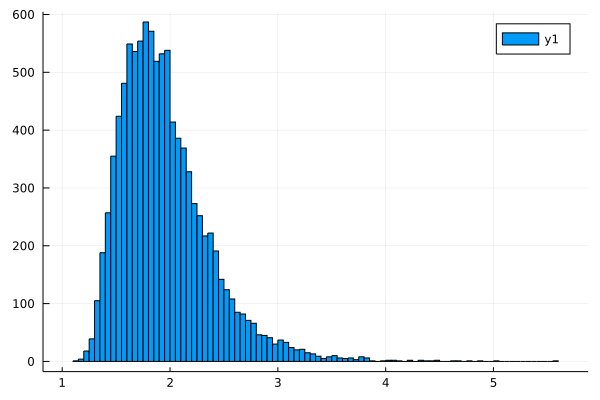

In [247]:
histogram(exp.(rand(dG,10000)))


In [ ]:
()